In [1]:
import glob
import numpy as np
import pandas as pd

from skelo.model.elo import EloEstimator

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=12)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
infiles = pd.Series(glob.glob('/home/daniel/wizepair2/notebooks/elo/elo-*.csv.gz'))
df = pd.concat(infiles.parallel_apply(pd.read_csv, compression='gzip').tolist()).sample(frac=0.2, replace=True)

In [4]:
df.publication_date_greatest = pd.to_datetime(df.publication_date_greatest)
df.sort_values('publication_date_greatest', inplace=True)
df.reset_index(inplace=True, drop=True)

In [5]:
df['label'] = df.standard_change=='increase'

In [6]:
df.head(3)

,mmp_delta_uuid,assay_id,standard_type,standard_change,doc_id_greatest,publication_date_greatest,fragment1,fragment2,radius,pref_name,chessleague_uuid,doc_id_partition,label
0,b8334fe5cf257c1871039602d533ce86,688107,IC50,increase,51887,1970-01-01,c41797e20650da06faef1019e2326091,3202cbbb94f86e917c3deee0dedb0cd3,3,ANY,6ad84f51535ccddcdf2e33ff9a840bd6,887,True
1,d2dfb8290127170291c8867c4b609a91,954324,IC50,decrease,51887,1970-01-01,69c025f823dde052472d0029f082fe4c,fe0ccb930f4a5b47df1bee5aa747dce3,4,ANY,168e6b30b67ecef449a5b66f4801d387,887,False
2,217194329a1f5c7111cc621fa2b51f91,1301869,AC50,increase,51887,1970-01-01,6b5091712c34b61cf99cea3c7ef15225,2ed8adc1514b7adacd95007d22d7658c,2,ANY,7ae53ed0d2696672f11b2e98320bed24,887,True


In [7]:
df.publication_date_greatest.quantile([0, 0.05, 0.5, 0.95, 1])

0.00   1970-01-01
0.05   1990-08-05
0.50   2010-01-21
0.95   2019-02-03
1.00   2021-01-01
Name: publication_date_greatest, dtype: datetime64[ns]

In [8]:
len(df.index)

18748231

In [9]:
from sklearn.model_selection import GridSearchCV

def elo_grid(df, return_ratings=False):
    
    # create a table where winner / loser is defined
    df = df.copy(deep=True).reset_index()
    if df.empty: return None

    model = EloEstimator(
            key1_field="fragment1",
            key2_field="fragment2",
            timestamp_field="publication_date_greatest",
            initial_time=pd.to_datetime('1970-01-01')
    )

    clf = GridSearchCV(
        model,
        param_grid={'default_k': [5, 10, 20, 40, 80, 160, 320]},
        refit=False,
        cv=[(df.index, df.index)],
        scoring='accuracy'
    ).fit(df, df['label'])

    return pd.DataFrame(clf.cv_results_)

In [10]:
df_elo_grid = df.groupby(['chessleague_uuid']).parallel_apply(elo_grid)

/home/daniel/anaconda3/envs/wizepair-env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 7.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/wizepair-env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/daniel/anaconda3/envs/wizepair-env/lib/python3.7/site-packages/skelo/model/base.py", line 460, in fit
    self.rating_model.update(winner, loser, timestamp)
  File "/home/daniel/anaconda3/envs/wizepair-env/lib/python3.7/site-packages/skelo/model/b

In [11]:
df_elo_grid.groupby('param_default_k').median()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,mean_test_score,std_test_score,rank_test_score
param_default_k,,,,,,,,
5,0.002525,0.0,0.003747,0.0,0.501247,0.501247,0.0,1.0
10,0.002281,0.0,0.003698,0.0,0.501276,0.501276,0.0,1.0
20,0.002268,0.0,0.003691,0.0,0.501282,0.501282,0.0,1.0
40,0.002266,0.0,0.003697,0.0,0.501246,0.501246,0.0,1.0
80,0.002269,0.0,0.003669,0.0,0.501241,0.501241,0.0,1.0
160,0.002267,0.0,0.003670,0.0,0.501277,0.501277,0.0,1.0
320,0.002258,0.0,0.003668,0.0,0.501241,0.501241,0.0,1.0


In [9]:
def elo(df, return_ratings=False):
    
    # create a table where winner / loser is defined
    if df.empty: return None
    
    # fit model
    model = EloEstimator(
        key1_field="fragment1",
        key2_field="fragment2",
        timestamp_field="publication_date_greatest",
        initial_time=pd.to_datetime('1970-01-01'),
        default_k=10
    ).fit(df, df.label)
    if return_ratings: return model.rating_model.to_frame()

    # calculate proba
    df['proba'] = model.transform(df, output_type='prob', strict_past_data=True)
    return df[['assay_id', 'mmp_delta_uuid', 'chessleague_uuid', 'proba', 'label']]
    

In [10]:
df_elo = df.groupby(['chessleague_uuid']).parallel_apply(elo)

In [11]:
df_elo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    0.000034
0.1    0.481089
0.5    0.500000
0.9    0.519398
1.0    1.000000
Name: proba, dtype: float64

In [12]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_elo.label, df_elo.proba)

0.5511807094552735

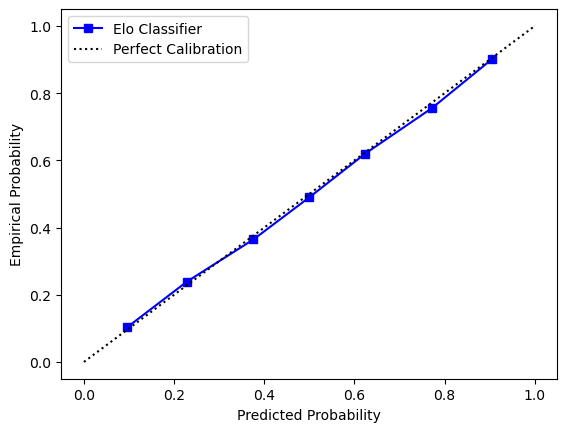

In [13]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_elo.label,
  df_elo.proba,
  n_bins=7
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [17]:
df_elo.sort_values('proba', ascending=False)

assay_id  \
chessleague_uuid                                      
7f2737dddb558e0912a66198bf7f00d6 34375246   1285832   
                                 40755928   1648485   
                                 41415502   1685777   
                                 41415505   1685776   
                                 34375213   1285832   
...                                             ...   
                                 44051319   1812209   
                                 44050567   1812208   
                                 44050568   1812209   
                                 44050570   1812208   
                                 44050555   1812208   

                                                             mmp_delta_uuid  \
chessleague_uuid                                                              
7f2737dddb558e0912a66198bf7f00d6 34375246  74ed8605746005833089cbac5d31a4aa   
                                 40755928  a0d18fc9a2dc165e13ed2f49ec89b723   
                                 41415502  c9c411436d426b44654f2cae6fb4935f   
                                 41415505  79c649f4236a3116418dcd8ccd02c794   
                                 34375213  9a80a09c246f5d629f49a0917a466e37   
...                                                                     ...   
                                 44051319  7f2e2506f4f8ac2d4f3031f65d309549   
                                 44050567  f7e7ff759620dc9e3028b205a02bf516   
                                 44050568  99a7594ca21b3fed16c543467954be2e   
                                 44050570  faf8fac97fe95242098ce8c4eae983e6   
                                 44050555  a6b38b7c59cdacc29b28bb68a966edff   

                                                           chessleague_uuid  \
chessleague_uuid                                                              
7f2737dddb558e0912a66198bf7f00d6 34375246  7f2737dddb558e0912a66198bf7f00d6   
                                 40755928  7f2737dddb558e0912a66198bf7f00d6   
                                 41415502  7f2737dddb558e0912a66198bf7f00d6   
                                 41415505  7f2737dddb558e0912a66198bf7f00d6   
                                 34375213  7f2737dddb558e0912a66198bf7f00d6   
...                                                                     ...   
                                 44051319  7f2737dddb558e0912a66198bf7f00d6   
                                 44050567  7f2737dddb558e0912a66198bf7f00d6   
                                 44050568  7f2737dddb558e0912a66198bf7f00d6   
                                 44050570  7f2737dddb558e0912a66198bf7f00d6   
                                 44050555  7f2737dddb558e0912a66198bf7f00d6   

                                                  proba  label  
chessleague_uuid                                                
7f2737dddb558e0912a66198bf7f00d6 34375246  1.000000e+00  False  
                                 40755928  1.000000e+00   True  
                                 41415502  1.000000e+00  False  
                                 41415505  1.000000e+00   True  
                                 34375213  1.000000e+00  False  
...                                                 ...    ...  
                                 44051319  2.818383e-31   True  
                                 44050567  2.818383e-31   True  
                                 44050568  2.818383e-31   True  
                                 44050570  2.818383e-31   True  
                                 44050555  2.818383e-31   True  

[46571700 rows x 5 columns]

In [ ]:
df_ratings = df.groupby(['chessleague_uuid']).parallel_apply(elo, return_ratings=True)

In [16]:
df_ratings.sort_values('rating', ascending=False)

key  \
chessleague_uuid                                                            
936b2ab0848ce64836a1671bab454d8a 23327   7d10e7b4bb13ce25d0cb6302f324cb69   
                                 23326   7d10e7b4bb13ce25d0cb6302f324cb69   
                                 23325   7d10e7b4bb13ce25d0cb6302f324cb69   
                                 23324   7d10e7b4bb13ce25d0cb6302f324cb69   
                                 23323   7d10e7b4bb13ce25d0cb6302f324cb69   
...                                                                   ...   
bf8a7ae5540c33788794ebe2792c31d7 265036  21ea6a5665fb4674223ddbbb4487a64b   
                                 265035  21ea6a5665fb4674223ddbbb4487a64b   
                                 265038  21ea6a5665fb4674223ddbbb4487a64b   
                                 265037  21ea6a5665fb4674223ddbbb4487a64b   
                                 265039  21ea6a5665fb4674223ddbbb4487a64b   

                                              rating valid_from   valid_to  
chessleague_uuid                                                            
936b2ab0848ce64836a1671bab454d8a 23327   2664.786349 2016-03-11 2016-03-11  
                                 23326   2664.761534 2016-02-06 2016-03-11  
                                 23325   2663.261604 2016-02-06 2016-02-06  
                                 23324   2663.260300 2016-02-06 2016-02-06  
                                 23323   2657.030607 2016-02-06 2016-02-06  
...                                              ...        ...        ...  
bf8a7ae5540c33788794ebe2792c31d7 265036   110.000000 2019-03-28        NaT  
                                 265035   100.000000 2019-03-28 2019-03-28  
                                 265038   100.000000 2019-03-28        NaT  
                                 265037    90.000000 2019-03-28 2019-03-28  
                                 265039    80.000000 2019-03-28        NaT  

[48585555 rows x 4 columns]

In [17]:
df_ratings[df_ratings.valid_to.isna()].to_csv('/home/daniel/wizepair2/elo_ratings.csv.gz', compression='gzip')